<a href="https://colab.research.google.com/github/Jaseelkt007/ML/blob/master/Diabetic_Retinopathy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from multiprocessing import Pool
import warnings
from tqdm import tqdm
import os
import torch
import matplotlib.pyplot as plt
import cv2

sample_data_path = '/content/drive/MyDrive/sample/test_data'
output_folder = '/content/drive/MyDrive/sample/test_resized'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#transform = transforms.Compose([
    #transforms.Resize((256,256)),
 #   transforms.RandomRotation(20),
  #  transforms.RandomHorizontalFlip(),
   # transforms.ColorJitter(brightness= 0.2, contrast = 0.2),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456,0.406], std= [0.229,0.224,0.225])
#])

def trim(image):

    percentage = 0.02
    img = np.array(image)
    img_gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY) # Convert to grayscale to simply the process
    # create the binary mask , to get the background from actual content
    img_gray = img_gray > 0.1 * np.mean(img_gray[img_gray!=0])
    # calculate the row wise and column wise sums to find where the significant content exists
    row_sums = np.sum(img_gray, axis = 1)
    col_sums = np.sum(img_gray, axis = 0)
    rows = np.where(row_sums > img.shape[1] * percentage)[0] # return the rows index of rows which contain atleast 2% of its content
    cols = np.where (col_sums > img.shape[0] * percentage)[0]
    # find the min and max rows and columns for croping
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    im_crop = img[min_row : max_row +1 , min_col : max_col+1]
    return Image.fromarray(im_crop)

def resize_main_aspect(image, desired_size):
    old_size = image.size
    ratio = float(desired_size)/ max(old_size) # resize ratio
    new_size = tuple([int(x * ratio) for x in old_size]) # (N,M) N,M are new size
    im = image.resize(new_size, Image.LANCZOS) # a filter to smooth image when resize, helps to reduce artifacts in the reduced image
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size - new_size[0])//2 , (desired_size - new_size[1])//2)) # paster the image on the new square background
    return new_im

def save_single(args): # helpfull for multiprocessing
    img_file, input_path_folder, output_path_folder, output_size = args
    image_org = Image.open(os.path.join(input_path_folder, img_file))
    image = trim(image_org)
    image = resize_main_aspect(image, desired_size= output_size[0])
    image.save(os.path.join(output_path_folder , img_file))



def multi_image_resize(input_path_folder, output_path_folder, output_size=None):
    if not output_size:
        warnings.warn("Need to specify output_size! For example: output_size=100")
        exit()

    if not os.path.exists(output_path_folder):
        os.makedirs(output_path_folder)

    jobs = [
        (file, input_path_folder, output_path_folder, output_size)
        for file in os.listdir(input_path_folder)
        if os.path.isfile(os.path.join(input_path_folder,file))
    ]

    with Pool() as p:
        list(tqdm(p.imap_unordered(save_single, jobs), total=len(jobs)))

#if __name__ == "__main__":
multi_image_resize(sample_data_path, output_folder, output_size = (256,256))


def preprocess_images(data_path, transform):
    processed_images = []
    for img_name in os.listdir(data_path):
        img_path = os.path.join(data_path, img_name)
        image = Image.open(img_path)
        image = trim(image)
        image_resized = resize_main_aspect(image, desired_size=256)
        image = transform(image_resized)
        processed_images.append(image)
    return processed_images

#processed_images = preprocess_images(sample_data_path, transform)

def show_images(images, n=5):
    fig, axs = plt.subplots(1, n , figsize=(15,5))
    for i , img in enumerate(images[:n]):
        img = img.permute(1,2,0) # change from C, H, W to H, W, C
        img = torch.clamp(img * torch.tensor([0.229,0.224,0.225]) +
                          torch.tensor([0.485,0.456,0.406]), 0,1) # denormalize
        axs[i].imshow(img)
        axs[i].axis("off")
    plt.show()

#show_images(processed_images,n=5)







100%|██████████| 103/103 [00:59<00:00,  1.72it/s]


In [ ]:
import os
import csv
from PIL import Image



resized_folder = '/content/drive/MyDrive/sample/test_resized'
final_folder = '/content/drive/MyDrive/sample/test_resized/binary'
csv_file_path = '/content/test.csv'


if not os.path.exists(final_folder):
    os.makedirs(final_folder)

# Create output folder structure for each class
for i in range(2):
    class_folder = os.path.join(final_folder, f'class_{i}')
    os.makedirs(class_folder, exist_ok=True)

with open(csv_file_path, encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    image_name_index = header.index("Image name")
    grade_index = header.index("label")

    # Loop through each row in CSV and process images based on class
    for row in tqdm(csv_reader, desc='Processing images', unit='image'):
        image_name = row[image_name_index]
        label = row[grade_index]

        # Load the preprocessed image
        img_path = os.path.join(resized_folder, f"{image_name}.jpg")
        if not os.path.exists(img_path):
            print(f"Warning: {img_path} doesn't exist")
            continue  # Skip if the file doesn't exist

        image = Image.open(img_path)
        class_folder = os.path.join(final_folder, f'class_{label}')

        # Save the original image in the respective folder
        original_image_name = f"{image_name}.jpg"
        if not os.path.exists(os.path.join(class_folder, original_image_name)):  # Save only if it doesn't exist
            image.save(os.path.join(class_folder, original_image_name))


Processing images: 103image [00:01, 70.80image/s]


In [ ]:
# Minor augmentation to balance the classes
import os
import csv
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

# Define augmentation functions for minor augmentation
def augment_image(image):  # Minor augmentation to balance the dataset
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.02),  # Small rotation
        tf.keras.layers.RandomBrightness(0.05),
        tf.keras.layers.RandomFlip("horizontal"),
    ])
    return data_augmentation(image)

# Paths and folders
preprocessed_folder = '/content/drive/MyDrive/sample/preprocessed_samples'
augmented_folder = '/content/drive/MyDrive/sample/aug_train_samples/binary'
csv_file_path = '/content/train.csv'

if not os.path.exists(augmented_folder):
    os.makedirs(augmented_folder)

# Create output folder structure for each class
for i in range(2):
    class_folder = os.path.join(augmented_folder, f'class_{i}')
    os.makedirs(class_folder, exist_ok=True)

# Set target augmentation limits (total count, including originals)
target_augmentation = {'0': 300, '1': 50}  # Total images needed per class
class_counters = {'0': 0, '1': 0}  # Track the count of images per class (original + augmented)

# Read the CSV file and process each image
with open(csv_file_path, encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    image_name_index = header.index("Image name")
    grade_index = header.index("label")

    # Loop through each row in CSV and process images based on class
    for row in tqdm(csv_reader, desc='Processing images', unit='image'):
        image_name = row[image_name_index]
        label = row[grade_index]
        label_str = str(label)

        # Load the preprocessed image
        img_path = os.path.join(preprocessed_folder, f"{image_name}.jpg")
        if not os.path.exists(img_path):
            print(f"Warning: {img_path} doesn't exist")
            continue  # Skip if the file doesn't exist

        image = Image.open(img_path)
        image_array = tf.keras.preprocessing.image.img_to_array(image)  # Convert PIL image to numpy array
        image_array = tf.image.convert_image_dtype(image_array, dtype=tf.float32)  # Scale pixel values to [0,1]

        # Define where to save images based on class label
        class_folder = os.path.join(augmented_folder, f'class_{label}')

        # Save the original image as `aug_0` for each file
        original_image_name = f"{image_name}_aug_0.jpg"
        if not os.path.exists(os.path.join(class_folder, original_image_name)):  # Save only if it doesn't exist
            image.save(os.path.join(class_folder, original_image_name))
            class_counters[label_str] += 1  # Count the augmented image

        # Generate one augmented image as `aug_1` only if the target count is not yet met
        if class_counters[label_str] < target_augmentation[label_str]:
            augmented_image = augment_image(image_array)
            augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image)  # Convert back to PIL image
            aug_image_name = f"{image_name}_aug_1.jpg"
            augmented_image.save(os.path.join(class_folder, aug_image_name))
            class_counters[label_str] += 1  # Count the augmented image

print("Original and augmented images saved with consistent naming.")

Processing images: 413image [00:17, 23.34image/s]

Original and augmented images saved with consistent naming.


Found 588 files belonging to 2 classes.
Found 103 files belonging to 2 classes.


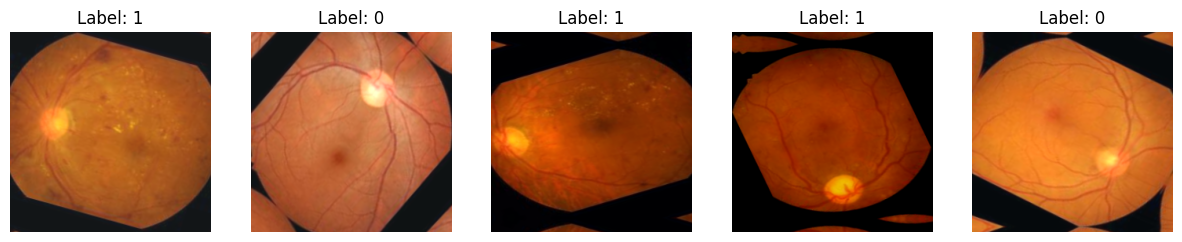

steps per epoch: 30
Validation images shape: (16, 256, 256, 3)
Time taken for one validation batch: 1.32 seconds
testimage batch shape:  (1, 256, 256, 3)
Time taken for one test batch: 1.62 seconds


In [2]:
# Load the dataset for training and testing
import tensorflow as tf
import logging
import time
import matplotlib.pyplot as plt
import numpy as np



batch_size = 16

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(factor=0.2),  # Approximately ±10 degrees,
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2), # small zoom
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomFlip("horizontal_and_vertical")
    ])

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

def preprocess(image, label, img_height=256, img_width=256):
    """Dataset preprocessing: Normalizing and resizing"""
    image = tf.image.resize(image, (img_height, img_width))
    # Normalize image to [0, 1] and resize
    image = tf.cast(image, tf.float32) / 255.0

    image = (image - [0.485, .456, 0.406])/ [0.229 , 0.224 ,0.225]
    '''
     [0.41187415 0.20350184 0.07076345] --> mean for training from scratch
     [0.31021136 0.16703175 0.08705007] --> standard deviation ""   ""
    '''

    return image, label



def load(name, data_dir, test_data_dir, batch_size= batch_size, caching=True):
    """Load datasets based on name"""
    if name == "idrid":
        logging.info(f"Preparing dataset {name}...")

        # Load dataset from directory structure, where each subdirectory represents a class,return an object, which is an iterable tuples (image, label)
        full_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            batch_size=batch_size,
            label_mode='int' # use 'int' for integer label , for classification
        )

        # Calculate the total number of examples
        num_examples = sum(1 for _ in full_ds)  # Calculate total number of examples
        for images, _ in full_ds.take(1):  # Get image shape
            image_shape = images.shape[1:]
            break

        class_names = full_ds.class_names
        num_classes = len(class_names)

        # Define df_info
        ds_info = {
            "num_examples" : num_examples,
            "features" : {
                "image" : {"shape" : image_shape , "dtype": tf.float32},
                "label" : {"num_classes": num_classes, "dtype": tf.int64}
            }
        }


        # Split into training and validation sets
        val_size = int(0.2 * num_examples)
        train_size = num_examples - val_size
        ds_train = full_ds.take(train_size )
        ds_val = full_ds.skip(train_size)

        steps_per_epoch = len(ds_train)

        # Load test data
        ds_test= None
        if test_data_dir:
            ds_test = tf.keras.preprocessing.image_dataset_from_directory(
                test_data_dir, batch_size = 1, label_mode = 'int'
            )


        # Denormalize and visualize images
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]

        # num_images = 5
        # # Get one batch of images and labels
        # for images, labels in ds_train.take(1):  # Take one batch

        #     # Denormalize the images
        #     images = (images * std) + mean  # Reverse normalization
        #     images = tf.clip_by_value(images, 0, 1)  # Ensure pixel values are in the range [0, 1]

        #     # Plot the images
        #     plt.figure(figsize=(15, 5))
        #     for i in range(num_images):
        #         plt.subplot(1, num_images, i + 1)
        #         plt.imshow(images[i].numpy())
        #         plt.title(f"Label: {labels[i]}")
        #         plt.axis("off")
        #     plt.show()
        #     break

        # Prepare and return the training and validation datasets
        return prepare(ds_train, ds_val, steps_per_epoch ,ds_test = ds_test, ds_info = ds_info ,batch_size=batch_size, caching=caching)


def prepare(ds_train, ds_val, steps_per_epoch , ds_test= None, ds_info=None, batch_size = batch_size , caching = True):
    """Prepare datasets with preprocessing, augmentation, batching, caching, and prefetching"""
    # Prepare training dataset
    ds_train = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if caching:
        ds_train = ds_train.cache()
    if ds_info:
        shuffle_buffer_size = ds_info.get("num_examples", 1000) // 10  # Default to 1000 if ds_info not provided
        ds_train = ds_train.shuffle(shuffle_buffer_size)
    else:
        ds_train = ds_train.shuffle(1000)  # Fallback shuffle size
    ds_train = ds_train.repeat().prefetch(tf.data.AUTOTUNE)

    # Prepare validation dataset (no augmentation)
    ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if caching:
        ds_val = ds_val.cache()
    ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

    # Prepare test dataset if available (no augmentation)
    if ds_test is not None:
        ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        if caching:
            ds_test = ds_test.cache()
        ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_val, ds_test, ds_info , steps_per_epoch




data_dir = '/content/drive/MyDrive/sample/aug_train_samples/binary'
test_data_dir = '/content/drive/MyDrive/sample/test_resized/binary'

#start = time.time()
ds_train , ds_val , ds_test, ds_info , steps_per_epoch = load("idrid" , data_dir, test_data_dir)

# # Denormalize and visualize images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

num_images = 5
# Get one batch of images and labels
for images, labels in ds_train.take(1):  # Take one batch

    # Denormalize the images
    images = (images * std) + mean  # Reverse normalization
    images = tf.clip_by_value(images, 0, 1)  # Ensure pixel values are in the range [0, 1]

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()
    break

# step = 0
# step_size = 2
# for images, labels in ds_train:
#     print(f"images: {images}, labels: {labels}")
#     step += 1
#     if step % step_size == 0:
#         break
# end = time.time()
# print(f"Time taken to load datasets: {end - start:.2f} seconds")


print(f"steps per epoch: {steps_per_epoch}")
start = time.time()
for images, labels in ds_val.take(1):
    print("Validation images shape:", images.shape)
    #print("Validation labels:", labels.numpy())
end = time.time()
print(f"Time taken for one validation batch: {end - start:.2f} seconds")

start = time.time()
for images, labels in ds_test.take(1):
    print("testimage batch shape: ", images.shape)
    #print("test Label batch shape :", labels.shape)
end = time.time()
print(f"Time taken for one test batch: {end - start:.2f} seconds")

In [41]:
from pickle import FALSE
from tensorflow.keras.layers import Input, Conv2D,MaxPool2D, Dense, Dropout, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import os
from datetime import datetime

log_dir = "logs"
train_summary_writer = tf.summary.create_file_writer(log_dir + "/train")
val_summary_writer = tf.summary.create_file_writer(log_dir + "/val")

save_dir = '/content/drive/MyDrive/sample/save_model'
os.makedirs(save_dir , exist_ok = True)

def save_model(model, model_name = 'final_model', add_timestamp=False):
    if add_timestamp:
        time_stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        save_path = os.path.join(save_dir, f"{model_name}_{time_stamp}.keras")
    else:
        # save the model in Keras V3 format
        save_path = os.path.join(save_dir, f"{model_name}.keras")
    model.save(save_path) # save in Tensorflow Savemodel format
    print(f"Model saved in Keras V3 format at : {save_path}")
    return save_path


# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

@tf.function
def train_step(model,images, labels):
    with tf.GradientTape() as tape:  # Corrected: Added parentheses after tf.GradientTape
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    # Calculate the gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradients to update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Update metrics
    train_loss.update_state(loss)
    train_accuracy.update_state(labels, predictions)

@tf.function
def val_step(model,images, labels):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)

    # Update metrics
    val_loss.update_state(loss)
    val_accuracy.update_state(labels, predictions)

def train_model(model, ds_train, ds_val, epochs, steps_per_epoch, save = True):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Reset metrics
        train_loss.reset_state()
        train_accuracy.reset_state()
        val_loss.reset_state()
        val_accuracy.reset_state()

        # Training loop
        for step ,(images, labels) in enumerate(ds_train):
            if step >= steps_per_epoch:
                break
            train_step(model, images, labels)

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

        # Validation loop
        for val_images, val_labels in ds_val:
            val_step(model,val_images, val_labels)

        with val_summary_writer.as_default():
            tf.summary.scalar('val_loss', val_loss.result(), step=epoch)
            tf.summary.scalar('val_accuracy', val_accuracy.result(), step=epoch)

        # Print metrics
        print(f"Train Loss: {train_loss.result():.4f}, Train Accuracy: {train_accuracy.result() * 100:.2f}%")
        print(f"Validation Loss: {val_loss.result():.4f}, Validation Accuracy:{val_accuracy.result() * 100:.2f}%")

    # Save the model
    if save:
        save_model(model, model_name = 'final_model_2')

# Load the pretrained Model VGG16
base_model_0 = tf.keras.applications.VGG16(
    input_shape=(256, 256, 3),
   include_top=False,
    weights="imagenet"
)


# Build the model
def build_model(base_model):

    inputs = Input(shape = (256,256,3))
    base_model.trainable = False
    x = base_model(inputs)
    x = Conv2D(8, kernel_size=(3,3), padding='same',activation='relu', kernel_regularizer=l2(1e-4))(x)
    #Dropout(0.3),
    #Conv2D(8, kernel_size=(3,3), padding='same',activation='relu' , kernel_regularizer=l2(1e-4)),
    x = MaxPool2D((2,2))(x)
    #Conv2D(8, kernel_size=(3,3), padding='same',activation='relu' , kernel_regularizer=l2(1e-4)),
    #Dropout(0.3),
    x = Conv2D(8, kernel_size=(3,3), padding='same',activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = MaxPool2D((2,2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256 ,kernel_regularizer=l2(1e-4))(x)                # Dense layer without activation
    x = LeakyReLU(negative_slope=0.01)(x)      # LeakyReLU with a small negative slope
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid' , kernel_regularizer=l2(1e-4))(x)  # Use sigmoid activation for binary classification
    model = Model(inputs = inputs, outputs = outputs)
    return model

model_vgg = build_model(base_model_0)
model_vgg.summary()

lr = 1e-4
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # Ensure from_logits=False for sigmoid output
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
epochs = 12

# Print layer trainability for debugging
for layer in model_vgg.layers:
    print(layer.name, layer.trainable)

# Train the model
train_model(model_vgg, ds_train, ds_val, epochs, steps_per_epoch , save = True)
# Unfreeze the last few layers of the base model
for layer in base_model_0.layers[-8:]:  # Unfreeze last 10 layers
    layer.trainable = True
lr=1e-4
epochs = 9
train_model(model_vgg, ds_train, ds_val,epochs,steps_per_epoch , save = True)


Model: "functional_227"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 8)             │          36,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,754,705 (56.28 MB)

 Trainable params: 40,017 (156.32 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

input_layer_14 True
vgg16 False
conv2d_4 True
max_pooling2d_2 True
conv2d_5 True
max_pooling2d_3 True
global_average_pooling2d_1 True
dense_2 True
leaky_re_lu_1 True
dropout_1 True
dense_3 True
Epoch 1/12
Train Loss: 0.7005, Train Accuracy: 51.25%
Validation Loss: 0.6915, Validation Accuracy:49.07%
Epoch 2/12
Train Loss: 0.6900, Train Accuracy: 54.38%
Validation Loss: 0.6855, Validation Accuracy:55.56%
Epoch 3/12
Train Loss: 0.6806, Train Accuracy: 58.54%
Validation Loss: 0.6742, Validation Accuracy:75.00%
Epoch 4/12
Train Loss: 0.6550, Train Accuracy: 70.62%
Validation Loss: 0.6375, Validation Accuracy:78.70%
Epoch 5/12
Train Loss: 0.6056, Train Accuracy: 75.00%
Validation Loss: 0.5744, Validation Accuracy:78.70%
Epoch 6/12
Train Loss: 0.5450, Train Accuracy: 77.50%
Validation Loss: 0.5107, Validation Accuracy:79.63%
Epoch 7/12
Train Loss: 0.4895, Train Accuracy: 80.62%
Validation Loss: 0.4611, Validation Accuracy:78.70%
Epoch 8/12
Train Loss: 0.4334, Train Accuracy: 83.75%
Validation

In [35]:
output = base_model_0.output
print(output.shape)

(None, 8, 8, 512)


In [42]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
save_dir = '/content/drive/MyDrive/sample/save_model'
save_path = f"{save_dir}/final_model_2.keras"
model_loaded = load_model(save_path)

model_loaded.summary()

accuracy_list = []
tp, fp, tn, fn = 0,0,0,0
for images, labels in ds_test:
    #print(f"size of ds_test :{len(ds_test)}")
    predictions = model_loaded(images, training=False)
    #print(f"predictions are {predictions}")
    predictions = tf.cast(predictions > 0.5 , tf.int32)

    matches = tf.cast(predictions == labels, tf.float32)
    batch_accuracy = tf.reduce_mean(matches)
    accuracy_list.append(batch_accuracy.numpy())

    # update confusion matrix
    tp += tf.reduce_sum(tf.cast((predictions==1) & (labels == 1), tf.int32))
    fp += tf.reduce_sum(tf.cast((predictions==1) & (labels == 0), tf.int32))
    tn += tf.reduce_sum(tf.cast((predictions==0) & (labels == 0), tf.int32))
    fn += tf.reduce_sum(tf.cast((predictions==0) & (labels == 1), tf.int32))

accuracy = sum(accuracy_list)/ len(accuracy_list)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0

print(f"Accuracy: {accuracy:.2%}")
print(f"Sensitivity (Recall): {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1-Score: {f1_score:.2%}")
print(f"Confusion Matrix : TP={tp}, FP={fp}, TN={tn}, FN={fn}")

print(model_vgg.input)


Model: "functional_227"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 8)             │          36,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,754,705 (56.28 MB)

 Trainable params: 13,019,217 (49.66 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Accuracy: 79.61%
Sensitivity (Recall): 78.12%
Specificity: 82.05%
Precision: 87.72%
F1-Score: 82.64%
Confusion Matrix : TP=50, FP=7, TN=32, FN=14
<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_2237>


In [5]:
!ls "/content/drive/MyDrive/sample/test_resized/binary/class_1"

IDRiD_001.jpg  IDRiD_012.jpg  IDRiD_023.jpg  IDRiD_036.jpg  IDRiD_061.jpg  IDRiD_083.jpg
IDRiD_002.jpg  IDRiD_013.jpg  IDRiD_024.jpg  IDRiD_040.jpg  IDRiD_062.jpg  IDRiD_084.jpg
IDRiD_003.jpg  IDRiD_014.jpg  IDRiD_025.jpg  IDRiD_042.jpg  IDRiD_064.jpg  IDRiD_086.jpg
IDRiD_004.jpg  IDRiD_015.jpg  IDRiD_026.jpg  IDRiD_046.jpg  IDRiD_065.jpg  IDRiD_087.jpg
IDRiD_005.jpg  IDRiD_016.jpg  IDRiD_027.jpg  IDRiD_048.jpg  IDRiD_066.jpg  IDRiD_088.jpg
IDRiD_006.jpg  IDRiD_017.jpg  IDRiD_028.jpg  IDRiD_049.jpg  IDRiD_067.jpg  IDRiD_089.jpg
IDRiD_007.jpg  IDRiD_018.jpg  IDRiD_031.jpg  IDRiD_051.jpg  IDRiD_072.jpg  IDRiD_091.jpg
IDRiD_008.jpg  IDRiD_019.jpg  IDRiD_032.jpg  IDRiD_053.jpg  IDRiD_076.jpg  IDRiD_100.jpg
IDRiD_009.jpg  IDRiD_020.jpg  IDRiD_033.jpg  IDRiD_057.jpg  IDRiD_079.jpg  IDRiD_102.jpg
IDRiD_010.jpg  IDRiD_021.jpg  IDRiD_034.jpg  IDRiD_059.jpg  IDRiD_081.jpg
IDRiD_011.jpg  IDRiD_022.jpg  IDRiD_035.jpg  IDRiD_060.jpg  IDRiD_082.jpg


input_layer_14
vgg16
conv2d_4
max_pooling2d_2
conv2d_5
max_pooling2d_3
global_average_pooling2d_1
dense_2
leaky_re_lu_1
dropout_1
dense_3
The last conv layer name is conv2d_5
Image loaded successfully!
Predicted class: 1
(1, 4, 4, 8)
(8,)
shape of heat map before colormap is (256, 256, 3)


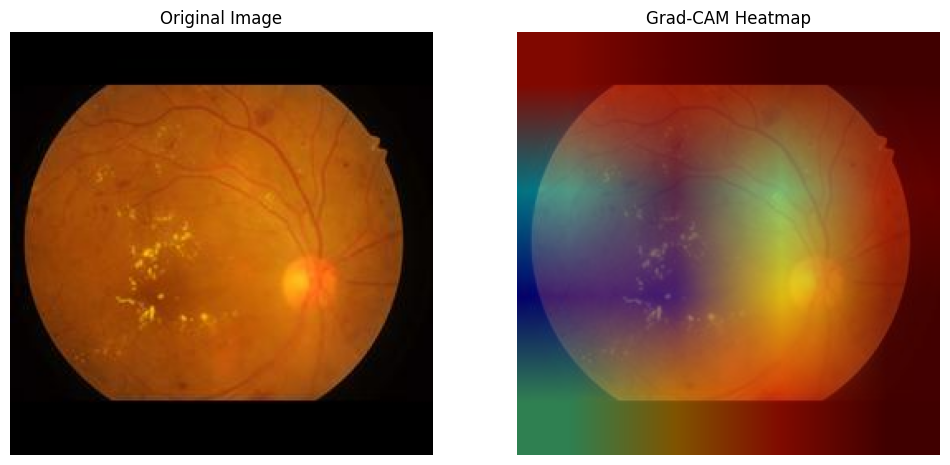

In [53]:
# GRAD CAM visualization
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os

# Load the saved model
save_path = '/content/drive/MyDrive/sample/save_model/final_model_2.keras'
model_loaded = load_model(save_path)

for layer in model_loaded.layers:
    print(layer.name)

last_conv_layer = None


for images, labels in ds_train.take(1):
        dummy_img = images[0:1]
        break
_ = model_loaded(dummy_img)

def find_target_layer(model):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(model.layers):
        # check to see if the layer has a 4D output
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name

last_conv_layer_name = find_target_layer(model_loaded)

if last_conv_layer_name:
    print(f"The last conv layer name is {last_conv_layer_name}")
else:
    print(f"No Convolutional Layers found in the model")

# Function to generate Grad-CAM
def grad_cam(model, img_path,ds_train, last_conv_layer_name, target_class_idx=None):
    """
    Generate Grad-CAM heatmap.

    Parameters:
      model: Trained model.
      img: Input image tensor (1, H, W, C).
      last_conv_layer_name (str): Name of the last convolutional layer.
      target_class_idx (optional): Target class index. If None, uses the predicted class.

    Returns:
      Heatmap normalized to the range [0, 1].
    """
    # Initialize the model,
    for images, labels in ds_train.take(1):
        dummy_img = images[0:1]
        break
    _ = model(dummy_img)

    # Load and preprocess the image
    image = cv2.imread(img_path) # Load image in BGR format

    if image is None:
        print(f"Error: File not found or cannot be opened at {img_path}")
    else:
        print("Image loaded successfully!")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = np.array(image) / 255.0  # Normalize the pixel values to [0, 1]
    img_array = np.expand_dims(image, axis=0)  # Add batch dimension
    img_tensor = tf.convert_to_tensor(img_array, dtype = tf.float32)

    # Predict using the model
    predictions = model(img_array, training=False)
    predictions = tf.sigmoid(predictions[:,0])
    print("Predicted class:", 1 if predictions[0] > 0.5 else 0)

    # Initialize a model for Grad-CAM
    grad_model = tf.keras.models.Model(
      inputs=model.input,
      outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Ensure that the input tensor is watched
        tape.watch(img_tensor)

        # Get outputs for the last conv layer and the predictions
        conv_outputs, predictions = grad_model(img_array)

        # Extract the target class score
        class_output = predictions[:, 0]

    # Calculate gradients of the target class score with respect to conv layer output
    grads = tape.gradient(class_output, conv_outputs)
    print(grads.shape)

    # Compute the mean intensity of the gradients for each feature map
    weights = tf.reduce_mean(grads, axis=(0, 1, 2)) # along, B, H, W
    print(weights.shape)

    # Compute the weighted sum of the feature maps
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    # Apply ReLU to retain only positive values
    cam = tf.maximum(cam, 0)

    # Normalize the heatmap
    cam /= tf.reduce_max(cam) if tf.reduce_max(cam) != 0 else 1

    return cam

# Function to display Grad-CAM
def display_grad_cam(heatmap, img, alpha=0.5):
    """
    Overlay Grad-CAM heatmap on the original image.

    Parameters:
      heatmap: Grad-CAM heatmap.
      img: Original image (H, W, C).
      alpha: Heatmap transparency factor.
    """
    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap) # size - (4,4)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Convert t 3 Channel - (256,256,3)

    # Rescale original image to uint8
    img = np.uint8(img * 255)

    heatmap = cv2.resize(heatmap,(img.shape[1], img.shape[0])) # resize to. (256,256)
    print(f"shape of heat map before colormap is {heatmap.shape}")

    if heatmap.shape[:2] != img.shape[:2]:
        print(f"the shape of heatmap is {heatmap.shape} ")
        print(f"the shape of image is {img.shape}")
        raise ValueError("The heatmap and image must have the same spatial dimensions.")

    # Overlay heatmap on original image
    overlayed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(overlayed_img)
    plt.axis("off")
    plt.show()

# Load and preprocess a test image
img_path = '/content/drive/MyDrive/sample/aug_train_samples/binary/class_1/IDRiD_001_aug_0.jpg'



# Generate Grad-CAM heatmap
heatmap = grad_cam(model_loaded, img_path, ds_train ,last_conv_layer_name)


# Load and preprocess the image
image = cv2.imread(img_path)  # Load image in BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
image = np.array(image) / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(image, axis=0)  # Add batch dimension

# Visualize the result
display_grad_cam(heatmap, image)

In [ ]:
accuracy_list = []
tp, fp, tn, fn = 0, 0, 0, 0

# Define weights for the models
vgg_weight = 0.4
resnet_weight = 0.6

for images, labels in ds_test:
    # Predictions from both models
    vgg_predictions = model_vgg(images, training=False)
    resnet_predictions = model_resnet(images, training=False)

    # Weighted average ensemble
    predictions = (vgg_weight * vgg_predictions + resnet_weight * resnet_predictions)
    predictions = tf.cast(predictions > 0.5, tf.int32)

    # Accuracy and confusion matrix calculations
    matches = tf.cast(predictions == labels, tf.float32)
    batch_accuracy = tf.reduce_mean(matches)
    accuracy_list.append(batch_accuracy.numpy())

    tp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 1), tf.int32))
    fp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 0), tf.int32))
    tn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 0), tf.int32))
    fn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 1), tf.int32))

accuracy = sum(accuracy_list) / len(accuracy_list)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0

print(f"Accuracy: {accuracy:.2%}")
print(f"Sensitivity (Recall): {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1-Score: {f1_score:.2%}")
print(f"Confusion Matrix : TP={tp}, FP={fp}, TN={tn}, FN={fn}")


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Step 1: Collect predictions from both models for training the meta-model
vgg_train_predictions = []
resnet_train_predictions = []
train_labels = []

for images, labels in ds_test:
    vgg_train_predictions.append(model_vgg(images, training=False).numpy())
    resnet_train_predictions.append(model_resnet(images, training=False).numpy())
    train_labels.extend(labels.numpy())

vgg_train_predictions = np.concatenate(vgg_train_predictions)
resnet_train_predictions = np.concatenate(resnet_train_predictions)
train_labels = np.array(train_labels)

# Combine predictions as features for the meta-model
train_features = np.stack([vgg_train_predictions, resnet_train_predictions], axis=1)

# Step 2: Train a meta-model
meta_model = LogisticRegression()
meta_model.fit(train_features, train_labels)

# Step 3: Use the meta-model for predictions on the test set
accuracy_list = []
tp, fp, tn, fn = 0, 0, 0, 0

for images, labels in ds_test:
    vgg_test_predictions = model_vgg(images, training=False).numpy()
    resnet_test_predictions = model_resnet(images, training=False).numpy()
    test_features = np.stack([vgg_test_predictions, resnet_test_predictions], axis=1)

    # Meta-model predictions
    predictions = meta_model.predict(test_features)
    predictions = tf.convert_to_tensor(predictions, dtype=tf.int32)

    # Accuracy and confusion matrix calculations
    matches = tf.cast(predictions == labels, tf.float32)
    batch_accuracy = tf.reduce_mean(matches)
    accuracy_list.append(batch_accuracy.numpy())

    tp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 1), tf.int32))
    fp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 0), tf.int32))
    tn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 0), tf.int32))
    fn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 1), tf.int32))

accuracy = sum(accuracy_list) / len(accuracy_list)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0

print(f"Accuracy: {accuracy:.2%}")
print(f"Sensitivity (Recall): {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1-Score: {f1_score:.2%}")
print(f"Confusion Matrix : TP={tp}, FP={fp}, TN={tn}, FN={fn}")


In [ ]:
accuracy_list = []
tp, fp, tn, fn = 0, 0, 0, 0

for images, labels in ds_test:
    # Predictions from both models
    vgg_predictions = tf.cast(model_vgg(images, training=False) > 0.5, tf.int32)
    resnet_predictions = tf.cast(model_resnet(images, training=False) > 0.5, tf.int32)

    # Stack predictions and perform majority voting
    stacked_predictions = tf.stack([vgg_predictions, resnet_predictions], axis=0)
    predictions = tf.reduce_mean(stacked_predictions, axis=0)
    predictions = tf.cast(predictions > 0.5, tf.int32)

    # Accuracy and confusion matrix calculations
    matches = tf.cast(predictions == labels, tf.float32)
    batch_accuracy = tf.reduce_mean(matches)
    accuracy_list.append(batch_accuracy.numpy())

    tp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 1), tf.int32))
    fp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 0), tf.int32))
    tn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 0), tf.int32))
    fn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 1), tf.int32))

accuracy = sum(accuracy_list) / len(accuracy_list)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0

print(f"Accuracy: {accuracy:.2%}")
print(f"Sensitivity (Recall): {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1-Score: {f1_score:.2%}")
print(f"Confusion Matrix : TP={tp}, FP={fp}, TN={tn}, FN={fn}")


In [ ]:
accuracy_list = []
tp, fp, tn, fn = 0, 0, 0, 0

# Define the concatenated Dense architecture for final classification
combined_dense_layers = tf.keras.Sequential([
    Dense(128, kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(64, kernel_regularizer=l2(1e-4)),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))
])

for images, labels in ds_test:
    # Extract feature maps from both models
    vgg_features = model_vgg.get_layer('flatten')(images)  # Assuming 'flatten' is the correct layer name
    resnet_features = model_resnet.get_layer('flatten')(images)

    # Concatenate feature maps
    combined_features = tf.concat([vgg_features, resnet_features], axis=1)

    # Pass concatenated features through the combined dense layers
    predictions = combined_dense_layers(combined_features)
    predictions = tf.cast(predictions > 0.5, tf.int32)

    # Accuracy and confusion matrix calculations
    matches = tf.cast(predictions == labels, tf.float32)
    batch_accuracy = tf.reduce_mean(matches)
    accuracy_list.append(batch_accuracy.numpy())

    tp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 1), tf.int32))
    fp += tf.reduce_sum(tf.cast((predictions == 1) & (labels == 0), tf.int32))
    tn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 0), tf.int32))
    fn += tf.reduce_sum(tf.cast((predictions == 0) & (labels == 1), tf.int32))

accuracy = sum(accuracy_list) / len(accuracy_list)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0

# Print results
print(f"Accuracy: {accuracy:.2%}")
print(f"Sensitivity (Recall): {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1-Score: {f1_score:.2%}")
print(f"Confusion Matrix : TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# Log metrics to TensorBoard
with eval_summary_writer.as_default():
    tf.summary.scalar("Accuracy", accuracy, step=0)
    tf.summary.scalar("Sensitivity (Recall)", sensitivity, step=0)
    tf.summary.scalar("Specificity", specificity, step=0)
    tf.summary.scalar("Precision", precision, step=0)
    tf.summary.scalar("F1-Score", f1_score, step=0)
    tf.summary.scalar("True Positives", tp, step=0)
    tf.summary.scalar("False Positives", fp, step=0)
    tf.summary.scalar("True Negatives", tn, step=0)
    tf.summary.scalar("False Negatives", fn, step=0)